In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


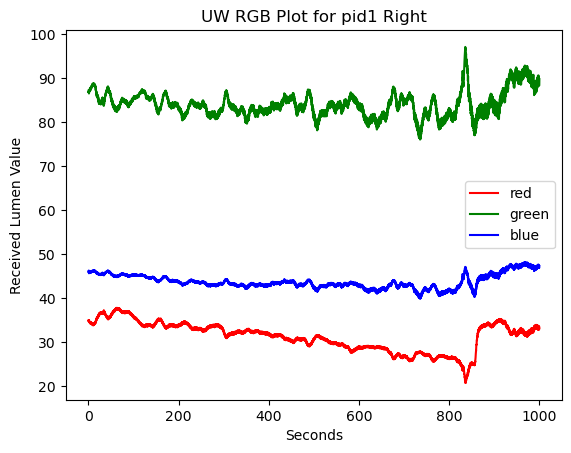

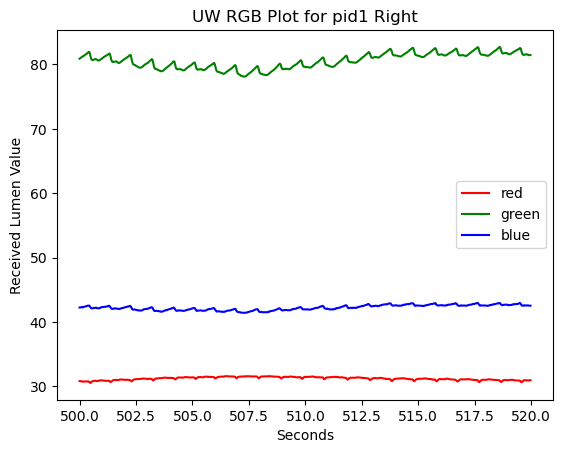

In [6]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [7]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

UW: mean=87.220673, std=9.325543


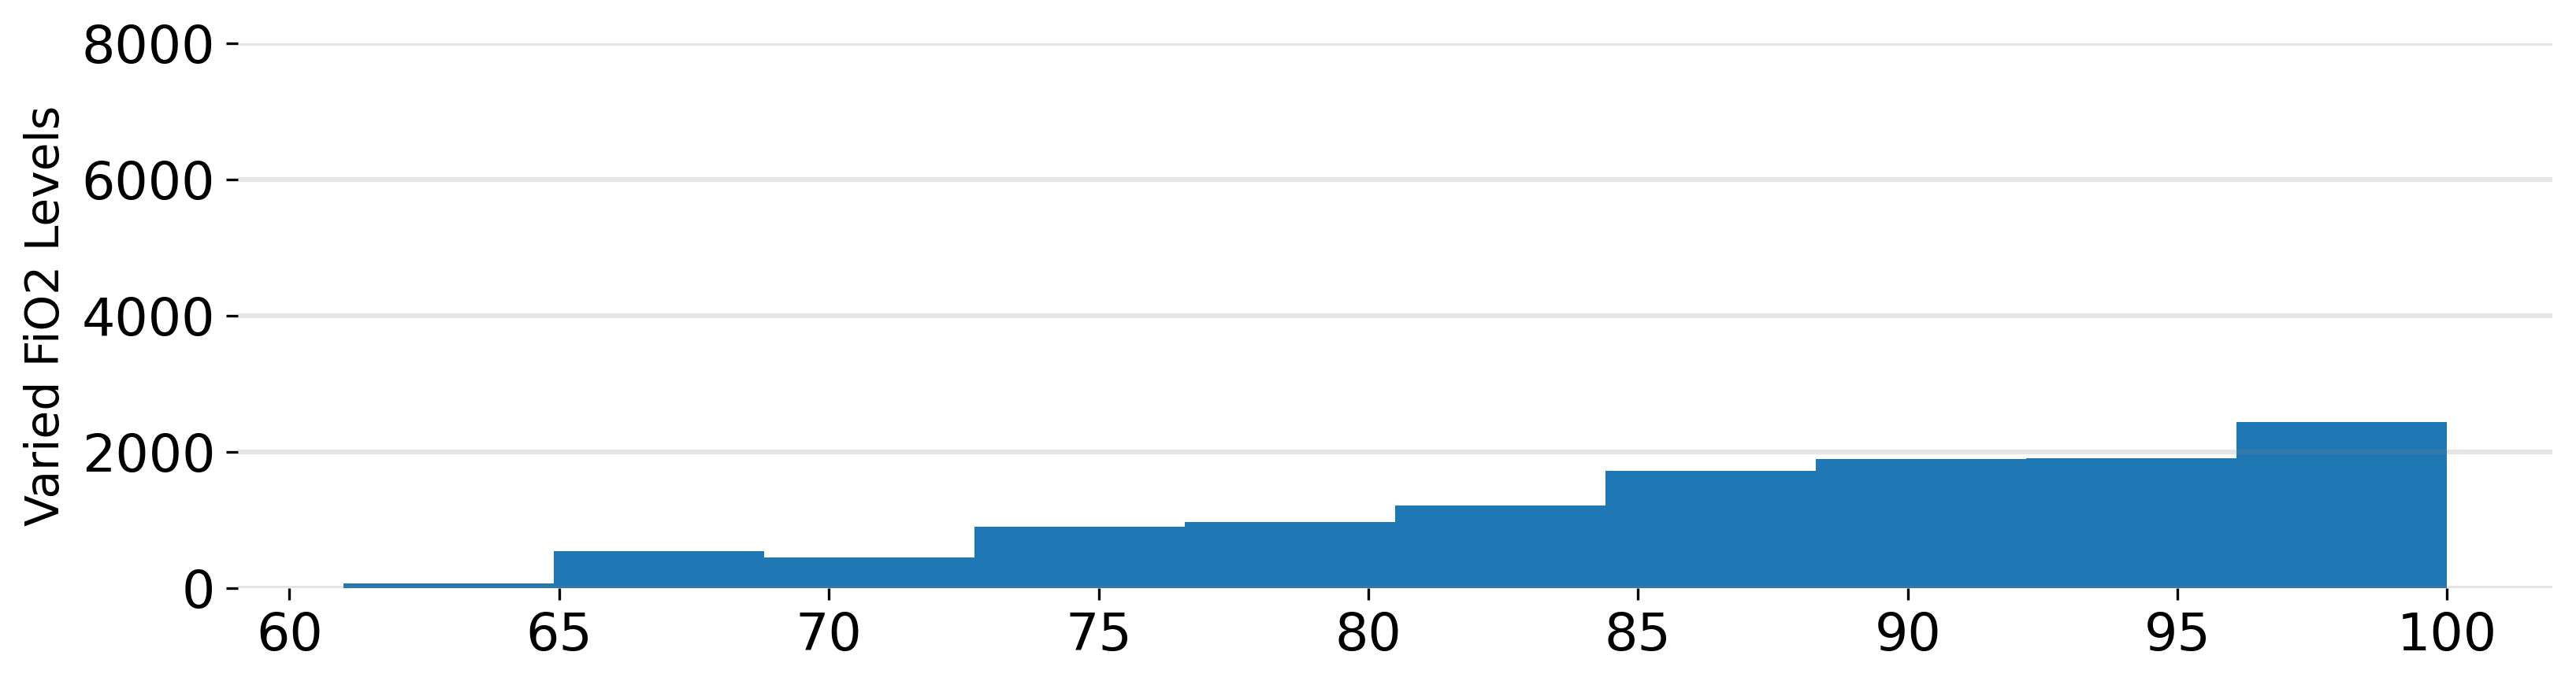

In [5]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [12]:
import os
print(os.path.exists(f'{PATH}/../gt/metadata.csv'))   # True 才是对的


False


In [13]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [14]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [40]:
# ==== Revised version: Optimal hand lag correct AC/DC normalization ====
import numpy as np
from scipy import signal
from scipy.signal import medfilt

def _acdc_score_bp_ac_over_dc(x_raw, x_bp):
    # AC: Amplitude after bandpass (95-5th percentile) DC: Original window mean
    ac = np.percentile(x_bp, 95, axis=1) - np.percentile(x_bp, 5, axis=1)
    dc = np.maximum(x_raw.mean(axis=1), 1e-6)
    return float((ac / dc).max())

def make_besthand_v3_with_lag_dcNorm(
    data, groundtruth, device_idx=0, lag_sec=0,
    fps=30, win=90, band=(0.5,8.0),
    mean_frac_thr=0.20, per_ch_std_thr=1e-3, acdc_thr=0.015,
    order=3, med_k=5
):
    L, R = slice(0,3), slice(3,6)
    b, a = signal.butter(order, [band[0]/(fps/2), band[1]/(fps/2)], btype="band")
    S, _, n_frames = data.shape
    n_secs = groundtruth.shape[-1]

    #  average DC value at the subject level (separated left and right, used for the relative brightness threshold)
    subj_mean_L = np.stack([np.nanmean(data[i, L, :], axis=1) for i in range(S)])
    subj_mean_R = np.stack([np.nanmean(data[i, R, :], axis=1) for i in range(S)])

    Xs, ys, owners = [], [], []
    for pid in range(S):
        baseL = np.maximum(subj_mean_L[pid], 1e-6)
        baseR = np.maximum(subj_mean_R[pid], 1e-6)
        for sec in range(1, n_secs-1):
            t = sec + lag_sec
            if t < 0 or t >= n_secs: 
                continue
            y = float(groundtruth[pid, device_idx, t])
            if not (70.0 <= y <= 100.0): 
                continue

            c = sec*fps; s, e = c - win//2, c + win//2
            if s < 0 or e > n_frames: 
                continue

            xL_raw = data[pid, L, s:e]; xR_raw = data[pid, R, s:e]
            if xL_raw.shape[-1] != win or xR_raw.shape[-1] != win:
                continue

            def pass_qc_and_make(x_raw, base):
                # Luminance/variance threshold
                if np.any(x_raw.mean(axis=1) < mean_frac_thr*base) or np.any(x_raw.std(axis=1) < per_ch_std_thr):
                    return None, -1.0
                # Bandpass (only for AC estimation.
                x_bp = np.zeros_like(x_raw, dtype=np.float32)
                for k in range(x_raw.shape[0]):
                    tmp = signal.filtfilt(b, a, x_raw[k], method="pad")
                    tmp = medfilt(tmp, kernel_size=med_k)
                    x_bp[k] = tmp
                # AC/DC score (AC uses bandpass amplitude, DC uses original mean)
                snr = _acdc_score_bp_ac_over_dc(x_raw, x_bp)
                if snr < acdc_thr:
                    return None, -1.0
                # Correct AC/DC normalization: With communication number ÷ original DC

                dc = np.maximum(x_raw.mean(axis=1, keepdims=True), 1e-6)  # Original mean
                x_norm = (x_bp / dc).astype(np.float32)                    # No longer do z-score
                return x_norm, snr

            L_pack = pass_qc_and_make(xL_raw, baseL)
            R_pack = pass_qc_and_make(xR_raw, baseR)
            okL, okR = L_pack[0] is not None, R_pack[0] is not None
            if not (okL or okR):
                continue

            # Choose the hand with a higher SNR
            x_pick = L_pack[0] if (okL and (not okR or L_pack[1] >= R_pack[1])) else R_pack[0]
            Xs.append(x_pick); ys.append(y); owners.append(pid)

    X = np.stack(Xs).astype(np.float32)   # (N, 3, win)
    y = np.array(ys, np.float32)
    own = np.array(owners, int)
    print(f"[besthand v3 + lag={lag_sec}s, dcNorm] X:", X.shape, "y:", y.shape)
    return X, y, own


In [41]:
# Fast lag scan (80 epochs, accelerated)
cands = [0, 10, 20, 30, 40, 50, 60]
res = []
for LAG in cands:
    Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(data, groundtruth, device_idx=DEVICE_IDX,
                                                  lag_sec=LAG, acdc_thr=0.015)
    y_t, y_p, per = run_loso_with_calibration(
        Xb, yb, ob, model_factory=lambda in_ch: Shallow1DCNN(in_ch),
        epochs=80, base_lr=3e-4, wd=5e-4, bs=256, patience=15, low_weight=8.0
    )
    mae = float(np.mean([r['mae'] for r in per])); 
    aa  = [r['a'] for r in per] if 'a' in per[0] else []
    print(f"[lag {LAG:>2}s] mean MAE={mae:.3f}%  a(median)≈{np.median(aa):.3f}")
    res.append((mae, LAG))
best_mae, BEST_LAG = sorted(res)[0]
print(f">>> pick lag = {BEST_LAG}s  (MAE={best_mae:.3f}%)")

# formal training（180 epoch）
Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(data, groundtruth, device_idx=DEVICE_IDX,
                                              lag_sec=BEST_LAG, acdc_thr=0.015)
y_true_b, y_pred_b, per_b = run_loso_with_calibration(
    Xb, yb, ob, model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
)
print("LOSO mean MAE =", np.mean([r['mae'] for r in per_b]))


[besthand v3 + lag=0s, dcNorm] X: (5111, 3, 90) y: (5111,)
device: mps
[LOSO+cal] held=0  test MAE=9.174%  n=378   (a=-0.020, b=89.881)
[LOSO+cal] held=1  test MAE=6.508%  n=1119   (a=-0.132, b=99.207)
[LOSO+cal] held=2  test MAE=7.250%  n=1026   (a=-0.014, b=89.656)
[LOSO+cal] held=3  test MAE=5.422%  n=1013   (a=-0.090, b=95.234)
[LOSO+cal] held=4  test MAE=7.133%  n=855   (a=0.043, b=84.884)
[LOSO+cal] held=5  test MAE=7.363%  n=720   (a=0.008, b=87.907)
[lag  0s] mean MAE=7.142%  a(median)≈-0.017
[besthand v3 + lag=10s, dcNorm] X: (5056, 3, 90) y: (5056,)
device: mps
[LOSO+cal] held=0  test MAE=9.113%  n=372   (a=-1.090, b=179.482)
[LOSO+cal] held=1  test MAE=6.503%  n=1110   (a=-0.233, b=107.364)
[LOSO+cal] held=2  test MAE=7.224%  n=1016   (a=-0.232, b=107.858)
[LOSO+cal] held=3  test MAE=5.528%  n=1003   (a=-0.588, b=136.358)
[LOSO+cal] held=4  test MAE=7.118%  n=845   (a=-0.389, b=121.012)
[LOSO+cal] held=5  test MAE=7.338%  n=710   (a=-0.409, b=122.922)
[lag 10s] mean MAE=7.13

LOSO mean MAE = 7.025089979171753
MAE=6.740%  RMSE=8.064%  R2=0.012
MAE 70-80% = 12.396%  (n=1017)
MAE 80-90% = 2.950%  (n=1923)
MAE 90-100% = 7.039%  (n=2339)
Thr<92%  Sens=1.000  Spec=0.000  (pos=3027, neg=1912)
Thr<90%  Sens=1.000  Spec=0.000  (pos=2600, neg=2339)
Thr<88%  Sens=0.489  Spec=0.623  (pos=2112, neg=2827)


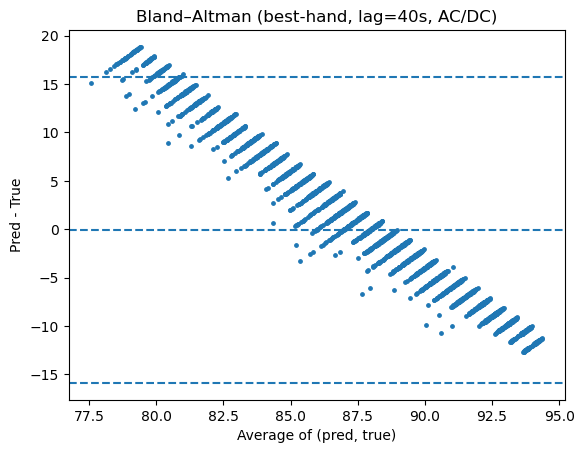

In [42]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix

BEST_LAG = 40  # 你上一步扫出来的最佳 lag

if 'y_true_b' not in globals() or 'y_pred_b' not in globals():
    Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(
        data, groundtruth, device_idx=DEVICE_IDX, lag_sec=BEST_LAG, acdc_thr=0.015
    )
    y_true_b, y_pred_b, per_b = run_loso_with_calibration(
        Xb, yb, ob, model_factory=lambda in_ch: Shallow1DCNN(in_ch),
        epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
    )

yt, yp = y_true_b, y_pred_b
print("LOSO mean MAE =", np.mean([r['mae'] for r in per_b]))

print(f"MAE={mean_absolute_error(yt, yp):.3f}%  RMSE={np.sqrt(np.mean((yt-yp)**2)):.3f}%  R2={r2_score(yt, yp):.3f}")
for lo, hi in [(70,80),(80,90),(90,100)]:
    m = (yt>=lo)&(yt<=hi)
    if m.any(): print(f"MAE {lo}-{hi}% = {mean_absolute_error(yt[m], yp[m]):.3f}%  (n={m.sum()})")

def sens_spec(y_true, y_pred, thr):
    yb = (y_true < thr).astype(int); pb = (y_pred < thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb, labels=[0,1]).ravel()
    return tp/(tp+fn+1e-8), tn/(tn+fp+1e-8), int(tp+fn), int(tn+fp)

for thr in [92.0, 90.0, 88.0]:
    s, p, pos_n, neg_n = sens_spec(yt, yp, thr)
    print(f"Thr<{thr:.0f}%  Sens={s:.3f}  Spec={p:.3f}  (pos={pos_n}, neg={neg_n})")

# Bland–Altman
diff = yp - yt; avg = 0.5*(yp + yt)
md, sd = diff.mean(), diff.std()
plt.figure(); plt.scatter(avg, diff, s=6)
plt.axhline(md, ls='--'); plt.axhline(md+1.96*sd, ls='--'); plt.axhline(md-1.96*sd, ls='--')
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True")
plt.title(f"Bland–Altman (best-hand, lag={BEST_LAG}s, AC/DC)"); plt.show()
